In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.manifold import TSNE
from dom_mis import generate_graph_from_similarity_matrix
import colorcet as cc
from ela_feature_definition import ela_feature_names
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [165]:
def plot_dom_mis_distribution_in_clusters(cluster_df, cluster_label_column):
    print(cluster_label_column)
    cluster_only=cluster_df[cluster_label_column]
    for algorithm in ['dominant','mis']:
        all_cluster_distributions=defaultdict(lambda: pd.DataFrame())
        for similarity_threshold in [0.9,0.95,0.97]:
            for run_id in range(0,30):
                ds_results=pd.read_csv(f'results/dropna/{algorithm}/{similarity_threshold}_{run_id}.csv',index_col=[0])

                ds_results=ds_results.merge(cluster_only, left_on=['suite','fid','iid'], right_index=True)
                ds_cluster_distribution=ds_results.groupby(cluster_label_column).count()['suite'].T
                all_cluster_distributions[f'{similarity_threshold}_{run_id}']=ds_cluster_distribution

        all_cluster_distributions_df=pd.DataFrame(all_cluster_distributions).fillna(0)

        fig, ax = plt.subplots(figsize=(20,5),sharey=True)
        ax.set_title(cluster_label_column)
        sns.heatmap(all_cluster_distributions_df,cmap=sns.color_palette("Paired", 8),ax=ax)
    

In [166]:
cluster_df_12 = pd.read_csv('data/hierarchical_clustering_12.csv',index_col=[0,1,2])
cluster_label_column_12='clustering_12_clusters'

In [167]:
cluster_df_sub_all = pd.read_csv('data/subclustering.csv',index_col=[0,1,2])

In [168]:

def plot_clusters(cluster_config, save=False):
    ela = pd.read_csv('data/aggregated_ela_representation_dropna.csv', index_col=[0,1,2])
    ela_2d=TSNE(n_components=2, metric='cosine').fit_transform(ela)
    ela_2d=pd.DataFrame(ela_2d, index=ela.index, columns=['x','y'])
    for cluster_config_name, cluster_config_values in cluster_config.items():
        
        
        df = cluster_config_values['data'].copy()
        ela_2d[cluster_config_name]= df[cluster_config_values['label_column']]
        ela_2d.plot.scatter(x='x',y='y',c=cluster_config_name,colormap="tab20c",legend=True,xlabel=None,ylabel=None)
        
        if save:
            
            plt.savefig(f'cluster_visualizations/{cluster_config_name}.pdf')
        

In [169]:
cluster_config={
               'cluster_12': {'data': cluster_df_12, 'label_column': cluster_label_column_12},
               }
selected_cluster_counts = [10,15]
for selected_cluster_count in selected_cluster_counts:
    cluster_label_column_sub=f'subclustering_{selected_cluster_count}_clusters'
    cluster_df_sub=cluster_df_sub_all[[cluster_label_column_sub]+ela_feature_names]
    cluster_config[f'cluster_sub_{selected_cluster_count}']={'data': cluster_df_sub, 'label_column': cluster_label_column_sub}

In [170]:
def analyze_single_clusters(cluster_df, cluster_label_column):
    cluster_sizes=pd.DataFrame(cluster_df[cluster_label_column].values).value_counts()
    single_clusters=[x[0] for x in cluster_sizes[cluster_sizes==1].index]
    single_cluster_indices = cluster_df[cluster_df[cluster_label_column].isin(single_clusters)].index
    
    
    
    for similarity_threshold in [0.9]:
        G = generate_graph_from_similarity_matrix(similarity_threshold)
        single_nodes = list(filter (lambda x: x[1]==0, G.degree))
        single_nodes=[x[0] for x in single_nodes]
        #sorted_nodes=sorted(G.degree, key=lambda x: x[1])[0:20]
        print(f'Single cluster indices: {len(single_cluster_indices)}')
        print(f'Similarity threshold: {similarity_threshold}')
        print(f'Single nodes: {len(single_nodes)}')
        print(f'Intersection: {len(set(single_cluster_indices).intersection(set(single_nodes)))}')
        print(f'Single clusters - single nodes : {len(set(single_cluster_indices).difference(set(single_nodes)))}')
        print(f'Single nodes - single clusters : {len(set(single_nodes).difference(set(single_cluster_indices)))}')
        print()
    

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


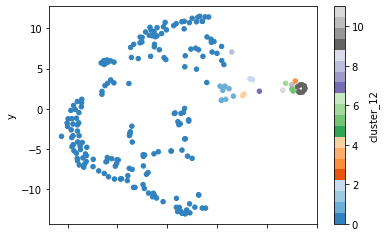

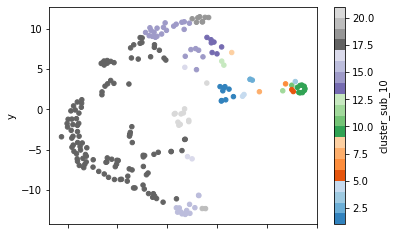

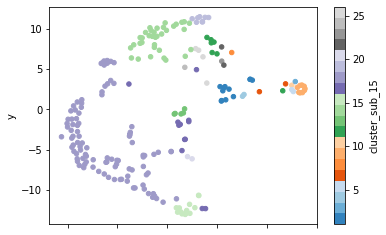

In [171]:
plot_clusters(cluster_config)

cluster_12
clustering_12_clusters
cluster_sub_10
subclustering_10_clusters
cluster_sub_15
subclustering_15_clusters


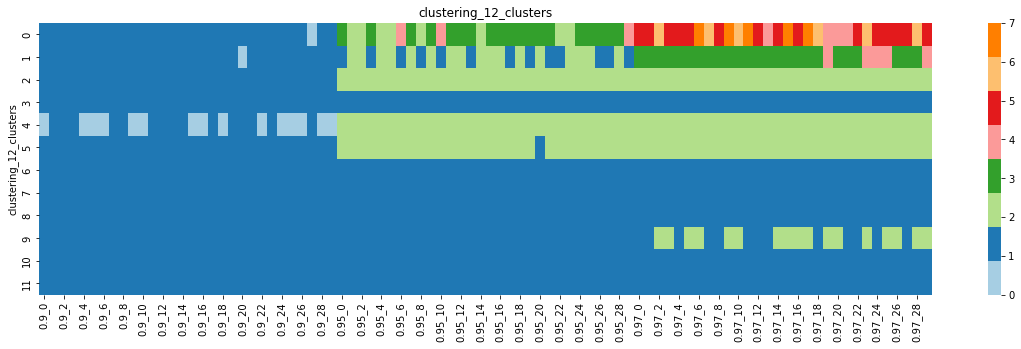

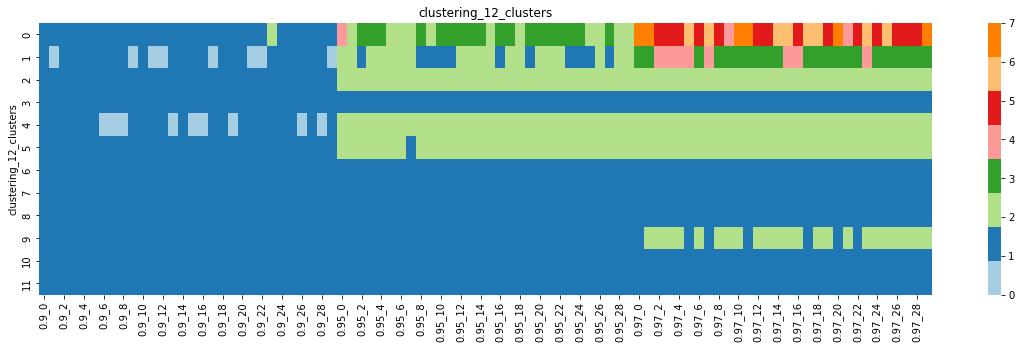

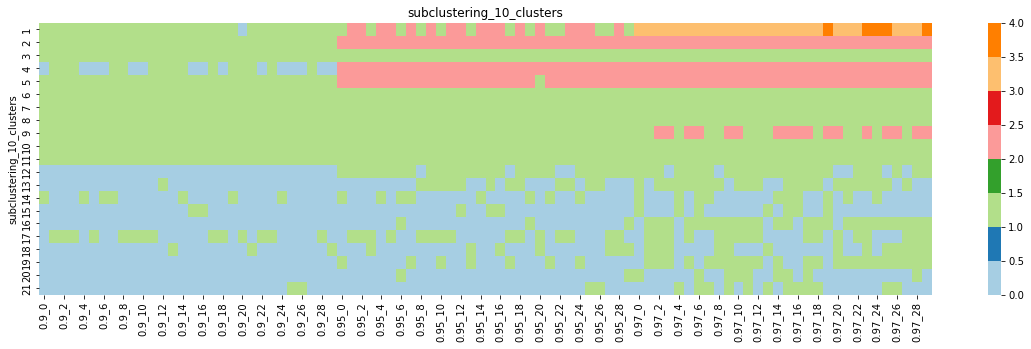

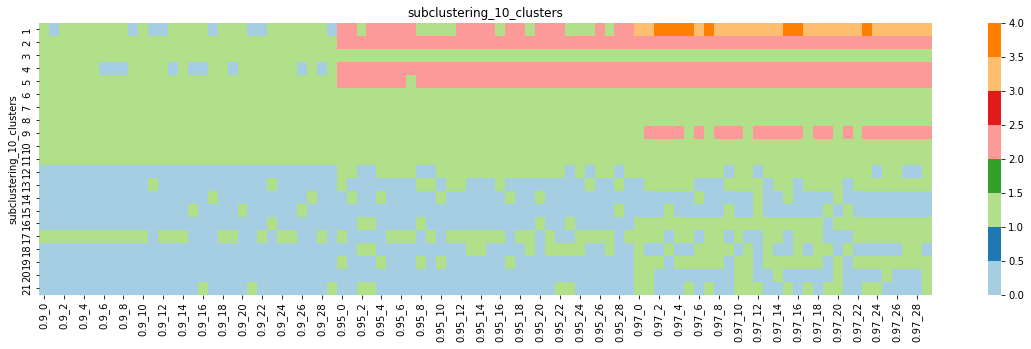

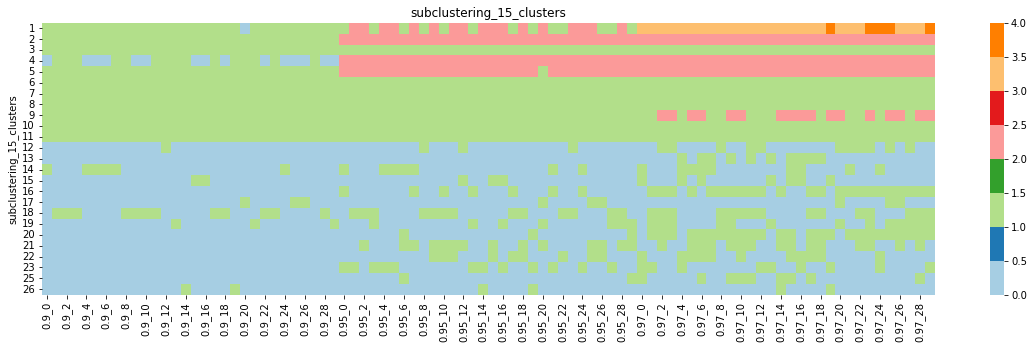

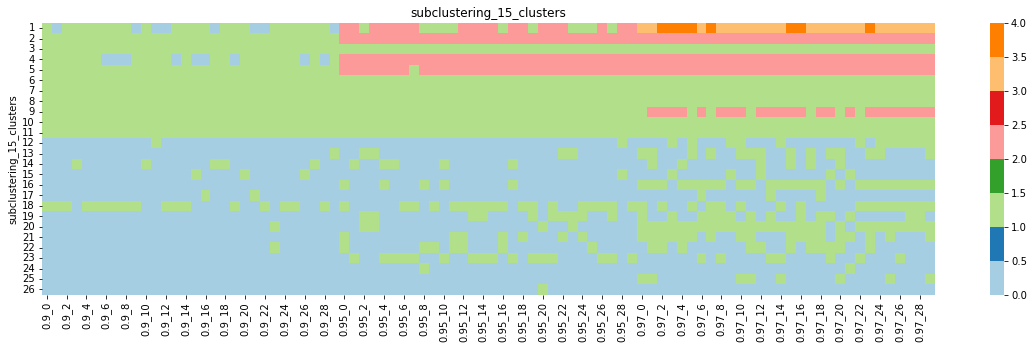

In [172]:
for cluster_config_name, cluster_config_values in cluster_config.items():
    print(cluster_config_name)
    plot_dom_mis_distribution_in_clusters(cluster_config_values['data'], cluster_config_values['label_column'])

In [173]:
for cluster_config_name, cluster_config_values in cluster_config.items():
    print(cluster_config_name)
    analyze_single_clusters(cluster_config_values['data'], cluster_config_values['label_column'])

cluster_12
Single cluster indices: 6
Similarity threshold: 0.9
Single nodes: 6
Intersection: 6
Single clusters - single nodes : 0
Single nodes - single clusters : 0

cluster_sub_10
Single cluster indices: 7
Similarity threshold: 0.9
Single nodes: 6
Intersection: 6
Single clusters - single nodes : 1
Single nodes - single clusters : 0

cluster_sub_15
Single cluster indices: 11
Similarity threshold: 0.9
Single nodes: 6
Intersection: 6
Single clusters - single nodes : 5
Single nodes - single clusters : 0



In [174]:
marker_dict = {'bbob': 'P', 'cec2013':'o', 'cec2014': 'v', 'cec2015':'s', 'cec2017':'*'}
colors = ['#000000,', '#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#000d9e','#619e00']
def save_clusters_for_overleaf(cluster_config):
    ela = pd.read_csv('data/aggregated_ela_representation_dropna.csv', index_col=[0,1,2])
    ela_2d=TSNE(n_components=2, metric='cosine').fit_transform(ela)
    ela_2d=pd.DataFrame(ela_2d, index=ela.index, columns=['x','y'])
    min_x, min_y, max_x, max_y=ela_2d['x'].min(), ela_2d['y'].min(), ela_2d['x'].max(), ela_2d['y'].max()
    for cluster_config_name, cluster_config_values in cluster_config.items():
        df = cluster_config_values['data'].copy()
        df_to_plot=ela_2d.copy()
        
        df_to_plot['cluster']= df[cluster_config_values['label_column']].copy()
        df_to_plot=df_to_plot.sort_values('cluster')
        print(df_to_plot['cluster'].drop_duplicates())
        df_to_plot=df_to_plot.reset_index().dropna()
        plt.figure(figsize=(7,5))
        ax = plt.subplot(111)
        df_to_plot['marker']=df_to_plot.suite.apply(lambda x: marker_dict[x])
        cluster_number=df_to_plot['cluster'].drop_duplicates().shape[0]
        seaborn_plot=sns.scatterplot(data=df_to_plot,x='x',y='y',hue='cluster', 
                                     palette=sns.color_palette(cc.glasbey, n_colors=cluster_number),
                                     style=df_to_plot['suite'], 
                                     legend='brief',ax=ax)
        #plt.legend( ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
        handles, labels = ax.get_legend_handles_labels()
        index_of_suite=labels.index('suite')

            
        labels = [l if l!='suite' else 'benchmark suite' for l in labels]

        ax.legend(handles, labels,ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))

        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.xlim([min_x-1,max_x+1])
        plt.ylim([min_y-1,max_y+1])
        #plt.show()
        #plt.tight_layout()
        plt.savefig(f'cluster_visualizations/{cluster_config_name}_per_suite.pdf', bbox_inches='tight')
        

suite    fid  iid
bbob     17   1      12
         14   1      12
         4    5      13
              4      13
              2      13
                     ..
cec2013  16   1      21
cec2015  7    1      21
bbob     16   3      21
cec2014  19   1      21
bbob     16   1      21
Name: subclustering_10_clusters, Length: 190, dtype: int64


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


suite    fid  iid
cec2017  30   1       0
bbob     1    1       1
         16   5       2
         23   5       3
         22   3       4
         1    3       5
         18   5       6
         19   4       7
         14   2       8
         22   1       9
         17   5      10
         1    4      11
Name: cluster, dtype: int64
suite    fid  iid
bbob     17   1       12
         14   5       13
         8    4       14
cec2013  18   1       15
cec2014  28   1       16
         23   1       17
bbob     2    1       18
cec2013  11   1       19
bbob     1    5       20
         5    1       21
         1    1      NaN
Name: cluster, dtype: object


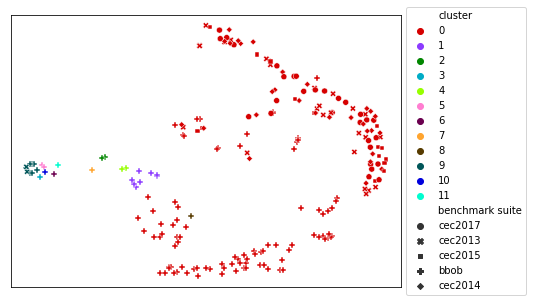

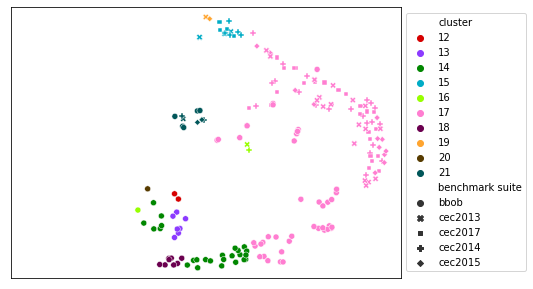

In [175]:
final_cluster_config={}
final_cluster_config['Initial 12 clusters']= cluster_config['cluster_12'].copy()
final_cluster_config['Final 21 clusters']= cluster_config['cluster_sub_10'].copy()

clusters_21_label=cluster_config['cluster_sub_10']['label_column']
clusters_21_data=cluster_config['cluster_sub_10']['data'].copy().sort_values(clusters_21_label)

clusters_12_15_data = clusters_21_data[clusters_21_data[clusters_21_label]>11].sort_values(clusters_21_label)
print(clusters_12_15_data[clusters_21_label])
clusters_12_15_data[clusters_21_label]=clusters_12_15_data[clusters_21_label].apply(lambda x: str(x))
final_cluster_config['Final 21 clusters']['data']= clusters_12_15_data

save_clusters_for_overleaf(final_cluster_config)

In [176]:
clusters_21_data=cluster_config['cluster_sub_10']['data'].copy()
clusters_21_label=cluster_config['cluster_sub_10']['label_column']

In [177]:
clusters_21_data[clusters_21_data[clusters_21_label]==17].shape

(119, 64)

In [178]:
for cluster_name in ['cluster_12','cluster_sub_10','cluster_sub_15']:
    cluster_df = cluster_config[cluster_name]['data']
    cluster_label = cluster_config[cluster_name]['label_column']
    cluster_sizes=pd.DataFrame(cluster_df[cluster_label].values).value_counts().sort_index()
    cluster_sizes.to_latex(f'cluster_visualizations/{cluster_name}.tex')

In [179]:
final_21_clusters = pd.read_csv('data/subclustering.csv',index_col=[0,1,2]).rename(columns={'subclustering_10_clusters':'cluster'})['cluster']

final_21_clusters=final_21_clusters.reset_index()

In [180]:
from collections import defaultdict
cluster_suite=defaultdict(lambda: {})
for suite in final_21_clusters['suite'].drop_duplicates().values:
    for cluster in final_21_clusters['cluster'].drop_duplicates().values:
        cluster_suite[cluster][suite]=final_21_clusters[(final_21_clusters['suite']==suite)&(final_21_clusters['cluster']==cluster)].shape[0]
cluster_suite_df=pd.DataFrame(cluster_suite).T
cluster_suite_df['total']=cluster_suite_df.sum(axis=1)

In [181]:
cluster_suite_df=cluster_suite_df.sort_index()
cluster_suite_df.columns=[c.upper() for c in cluster_suite_df.columns]

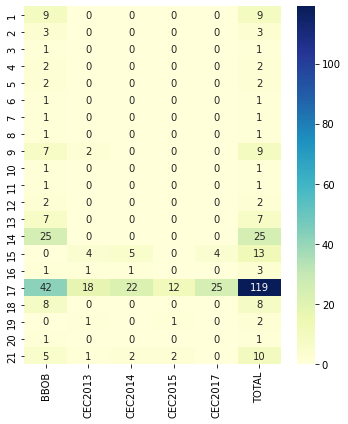

In [182]:
plt.figure(figsize=(5,6))
sns.heatmap(cluster_suite_df, cmap="YlGnBu", annot=True, fmt="d")
plt.tight_layout()
plt.savefig('cluster_visualizations/benchmarks_per_cluster_counts.pdf',pad_inches=0,bbox_inches=0)